
# Adjusting Incidence for Positive Rate, Hospital Occupancy and Vaccination 

## Load and Prepare Data

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

In [2]:
# load data [30Mb!]
full_data = pd.read_csv('owid-covid-data.csv')
# docu at: https://github.com/owid/covid-19-data/tree/master/public/data
# 100k rows, 60 cols

# convert date variable to pd.Timestamp object
full_data.date = pd.to_datetime(full_data.date)

In [49]:
# Extract Relevant Columns and Group By Country
cases_icu = full_data[['location',  'date', 'new_cases_smoothed_per_million', 'positive_rate',
                               'icu_patients_per_million', 'people_fully_vaccinated_per_hundred',
                               'weekly_icu_admissions_per_million']]

# Add Column for adjusted Incidence
# Parameterize influence of Positive Rate
x = 2
adj_incidence = cases_icu['new_cases_smoothed_per_million']*(cases_icu['positive_rate']*100)**x
cases_icu.insert(loc=0, column='adj_incidence', value=adj_incidence)
cases_icu_grouped = cases_icu.groupby('location')

In [40]:
# Get names of locations/ countries for which ICU data is available
icu_admissions_countries = []
icu_countries = []

for location, group in cases_icu_grouped:
    if not group['weekly_icu_admissions_per_million'].isnull().values.all():
        icu_admissions_countries.append(location)
    if not group['icu_patients_per_million'].isnull().values.all():
        icu_countries.append(location)
        
print('Weekly ICU-Admissions available for: \n', icu_admissions_countries, '\n')
print('ICU-Patients (on a given day) available for: \n', icu_countries)

Weekly ICU-Admissions available for: 
 ['Cyprus', 'Czechia', 'Estonia', 'France', 'Greece', 'Ireland', 'Israel', 'Latvia', 'Liechtenstein', 'Lithuania', 'Malta', 'Netherlands', 'Norway', 'Slovenia', 'Spain', 'Sweden'] 

ICU-Patients (on a given day) available for: 
 ['Algeria', 'Austria', 'Belgium', 'Bulgaria', 'Canada', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Ireland', 'Israel', 'Italy', 'Luxembourg', 'Netherlands', 'Portugal', 'Romania', 'Slovenia', 'Spain', 'Sweden', 'United Kingdom', 'United States']


## Correct Incidence for Positive Rate

0      1
1      1
2      1
3      1
4      1
      ..
520    1
521    1
522    1
523    1
524    1
Name: bla, Length: 525, dtype: int64
525     1
526     1
527     1
528     1
529     1
       ..
1056    1
1057    1
1058    1
1059    1
1060    1
Name: bla, Length: 536, dtype: int64
1061    1
1062    1
1063    1
1064    1
1065    1
       ..
1580    1
1581    1
1582    1
1583    1
1584    1
Name: bla, Length: 524, dtype: int64
1585    1
1586    1
1587    1
1588    1
1589    1
       ..
2104    1
2105    1
2106    1
2107    1
2108    1
Name: bla, Length: 524, dtype: int64
2109    1
2110    1
2111    1
2112    1
2113    1
       ..
2622    1
2623    1
2624    1
2625    1
2626    1
Name: bla, Length: 518, dtype: int64
2627    1
2628    1
2629    1
2630    1
2631    1
       ..
3122    1
3123    1
3124    1
3125    1
3126    1
Name: bla, Length: 500, dtype: int64
3127    1
3128    1
3129    1
3130    1
3131    1
       ..
3292    1
3293    1
3294    1
3295    1
3296    1
Name: bla, Length: 

Name: bla, Length: 528, dtype: int64
54396    1
54397    1
54398    1
54399    1
54400    1
        ..
54837    1
54838    1
54839    1
54840    1
54841    1
Name: bla, Length: 446, dtype: int64
54842    1
54843    1
54844    1
54845    1
54846    1
        ..
55341    1
55342    1
55343    1
55344    1
55345    1
Name: bla, Length: 504, dtype: int64
55346    1
55347    1
55348    1
55349    1
55350    1
        ..
55857    1
55858    1
55859    1
55860    1
55861    1
Name: bla, Length: 516, dtype: int64
55862    1
55863    1
55864    1
55865    1
55866    1
        ..
56373    1
56374    1
56375    1
56376    1
56377    1
Name: bla, Length: 516, dtype: int64
56378    1
56379    1
56380    1
56381    1
56382    1
        ..
56893    1
56894    1
56895    1
56896    1
56897    1
Name: bla, Length: 520, dtype: int64
56898    1
56899    1
56900    1
56901    1
56902    1
        ..
57420    1
57421    1
57422    1
57423    1
57424    1
Name: bla, Length: 527, dtype: int64
57425    1
5742

99888     1
99889     1
99890     1
99891     1
99892     1
         ..
100434    1
100435    1
100436    1
100437    1
100438    1
Name: bla, Length: 551, dtype: int64
100439    1
100440    1
100441    1
100442    1
100443    1
         ..
100983    1
100984    1
100985    1
100986    1
100987    1
Name: bla, Length: 549, dtype: int64
100988    1
100989    1
100990    1
100991    1
100992    1
         ..
101541    1
101542    1
101543    1
101544    1
101545    1
Name: bla, Length: 558, dtype: int64
101546    1
101547    1
101548    1
101549    1
101550    1
         ..
102048    1
102049    1
102050    1
102051    1
102052    1
Name: bla, Length: 507, dtype: int64
102053    1
102054    1
102055    1
102056    1
102057    1
         ..
102553    1
102554    1
102555    1
102556    1
102557    1
Name: bla, Length: 505, dtype: int64
102558    1
102559    1
102560    1
102561    1
102562    1
         ..
102818    1
102819    1
102820    1
102821    1
102822    1
Name: bla, Length: 265,

In [41]:
# any problems with NAs?
cases_icu_grouped.get_group('Israel').adj_incidence

47419          NaN
47420          NaN
47421          NaN
47422          NaN
47423          NaN
           ...    
47943    696.39427
47944    719.57047
47945          NaN
47946          NaN
47947          NaN
Name: adj_incidence, Length: 529, dtype: float64

## Inspect Results Visually: Correlation with ICU <u> Admissions </u>

<ipython-input-22-461218364ae1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.interpolate(method='linear', inplace=True)


KeyError: 'adj_incidence'

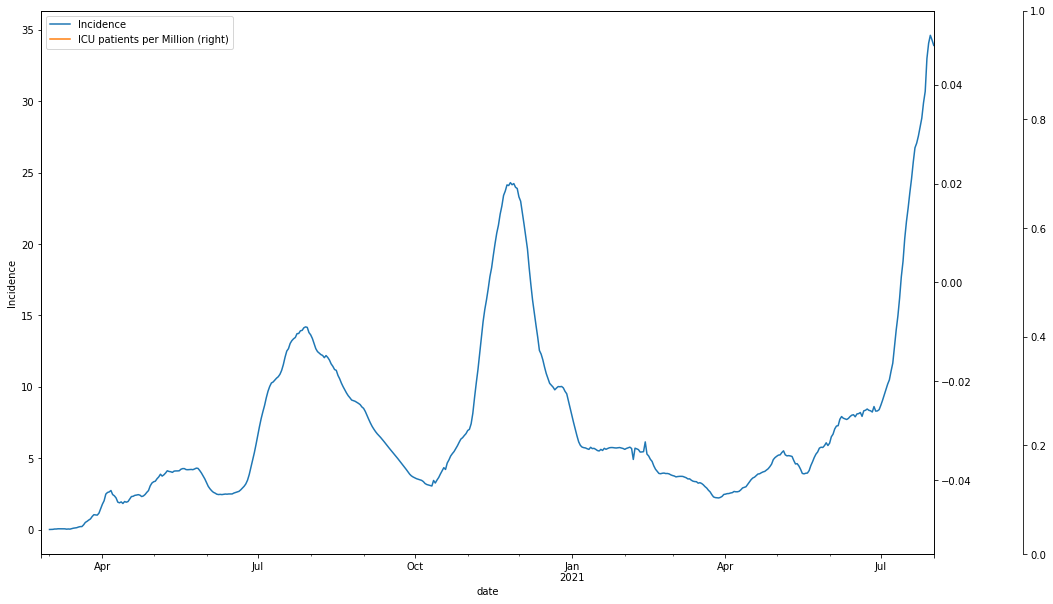

In [22]:
# Plot ICU Admissions, smoothed case numbers and positive rate

for country in icu_countries:
    df = cases_icu_grouped.get_group(country)
    # interpolate ICU occupancy linearly
    df.interpolate(method='linear', inplace=True)

    fig, ax = plt.subplots(figsize=(16,10))
    # for third variable
    ax2 = ax.twinx()
    ax2.spines['right'].set_position(('axes', 1.1))
    
    df.plot(x='date', y='new_cases_smoothed_per_million', kind='line', 
                  ylabel='Incidence', ax=ax, label='Incidence')
    df.plot(x='date', y='weekly_icu_admissions_per_million', kind='line', ax=ax,
            secondary_y=True, linestyle='solid',
           label='ICU patients per Million')
    df.plot(x='date', y='adj_incidence', kind='line', ax=ax2, color='red',
           label='Positive Rate', ylabel='Adjusted Incidence')
    
    ax.set_title(str(df['location'].unique()[0]))
    ax.right_ax.set_ylabel('ICU admissions per Million')
    ax.set_xlabel('Date')
    ax2.legend(frameon=False)
    
#    fig.savefig('fig4paper/icu_occupancy/icu_occupancy_' + country + '.pdf', bbox_inches='tight')

## Old Notes

<u> Method for Evaluation </u>

<b> Premise: </b> Metric shall not be too complex in order to communicate properly to the general public why measures are taken.
Thus we do not aim at developing the most predictive metric, but one that is intuitive to communicate, accounts for the current ICU occupancy and considers testing behaviour to counteract the aforementioned illusions of Case Numbers.

<b> Consequence: </b>
Fit one dimensional linear regression of ICU occupancy onto Pandemic Severity Metric (PSM) and compare $R^2$ to case Numbers.

$\rightarrow$ Figure Out technical details. Time Shift for x? Fit Models on Sliding Window? Go from High Level Perspective downwards: How are Policies guided right now?